In [29]:
from dolfin import *
%matplotlib inline

import ufl
import matplotlib.pyplot as plt
import time
import numpy as np
from dolfin import *
comm = MPI.comm_world  # MPI communicator

import meshio
import pygmsh
import numpy as np

In [30]:
# model = "stress_cdf"
model = "strain_cdf"
is_adaptive = False

In [31]:
# ---------------------------------------------------------------------------------
# MATERIAL PARAMETERS     ------------------------------------------------
# ---------------------------------------------------------------------------------
E1 = 3e4  # MPa
nu = 0
E0 = Expression("x[0] <= 100 ?  E1 + (r*E1-E1)/100 * (100-x[0]) : E1 + (r*E1-E1)/100 * (x[0]-100)  ",degree=1,  E1 = E1,r=2)
ft = 3  # MPa
Gc = 0.008  # MPa
Y0 = 0#ft**2/(2*E1) #Limiting crack driving energy


# E0 = 600  # MPa
ci = 1

nu = 0.2
mu = E0 / (2 * (1 + nu))
lmbda = E0 * nu / ((1 + nu) * (1 - 2 * nu))

# ---------------------------------------------------------------------------------
# SIMULATION PARAMETERS        ------------------------------------------------
# ---------------------------------------------------------------------------------
disp_current = 0.0 
max_disp = 0.025
deltaU = 1e-4
ms_tol = 1e-6

l = 1.5*27/256*E1 * Gc / ft ** 2
target_hmin = l/4

In [32]:
l

4.21875

In [33]:
# ft = 9#np.sqrt(27*E0*Gc/256/l) # MPa
sigmac = ft  # critical stress only for stress based method

Y0 = ft**2/(2*E0) #Limiting crack driving energy
energy_thsd = Y0

In [34]:
Gc = 256*ft**2*l/27/E1
Gc

0.012

In [35]:
# E0 * Gc / ft ** 2

In [36]:
ft, Y0

(3,
 Division(IntValue(9), Product(IntValue(2), Coefficient(FunctionSpace(None, FiniteElement('Lagrange', None, 1)), 75709))))

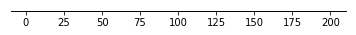

In [37]:
div = int(200/target_hmin)
mesh = IntervalMesh(div, 0, 200)

plot(mesh)

In [38]:
mesh.num_cells()

189

In [39]:

# ---------------------------------------------------------------------------------
# PARAMETERS FOR PARALLEL COMPUTATIONS   -----------------------------
# ---------------------------------------------------------------------------------

rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes


def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


# ---------------------------------------------------------------------------------
# SET SOME COMMON FENICS FLAGS     ---------------------------------------
# ---------------------------------------------------------------------------------
set_log_level(50)
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["cpp_optimize"] = True

In [40]:
# ---------------------------------------------------------------------------------
# MATERIAL MODEL  --------------------------------------------------------
# ---------------------------------------------------------------------------------
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)


def sigma(u):
    return 2.0 * mu * epsilon(u) + lmbda * tr(epsilon(u)) * Identity(len(u))

# -----------------------------------------------------------------------------
# 3D eigen decomposition
# -----------------------------------------------------------------------------


def invariants_principal(A):
    """Principal invariants of (real-valued) tensor A.
    https://doi.org/10.1007/978-3-7091-0174-2_3
    """
    i1 = ufl.tr(A)
    i2 = (ufl.tr(A)**2 - ufl.tr(A * A)) / 2
    i3 = ufl.det(A)
    return i1, i2, i3


def invariants_main(A):
    """Main invariants of (real-valued) tensor A.
    https://doi.org/10.1007/978-3-7091-0174-2_3
    """
    j1 = ufl.tr(A)
    j2 = ufl.tr(A * A)
    j3 = ufl.tr(A * A * A)
    return j1, j2, j3


def get_eigenstate(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

# ---------------------------------------------------------------------------------
# ENERGY CALCULATIONS        ------------------------------------------------
# ---------------------------------------------------------------------------------

# Apply some scalar-to-scalar mapping `f` to each component of `T`:


# def applyElementwise(f, T):
#     from ufl import shape


#     sh = shape(T)
#     if len(sh) == 0:
#         return f(T)
#     fT = []
#     for i in range(0, sh[0]):
#         fT += [applyElementwise(f, T[i, i])]
#     return as_tensor([[fT[0], 0], [0, fT[1]]])

# Apply some scalar-to-scalar mapping `f` to each component of `T`:
def applyElementwise(f, T, dim=2):
    from ufl import shape

    if model == "stress_cdf":
        sh = shape(T)
        if len(sh) == 0:
            return f(T)
        fT = []
        for i in range(0, sh[0]):
            fT += [applyElementwise(f, T[i, i])]
        return as_tensor([[fT[0], 0], [0, fT[1]]])
    else:
        sh = shape(T)
        if len(sh) == 0:
            return f(T)
        fT = []
        for i in range(0, sh[0]):
            # if dim == 2:
            fT += [applyElementwise(f, T[i, i], dim)]
            # else:
            #     fT += [applyElementwise(f, T[i],dim)]
        return as_tensor(fT)

def split_plus_minus(T):
    x_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), T)
    x_minus = applyElementwise(lambda x: 0.5 * (abs(x) - x), T)
    return x_plus, x_minus


def safeSqrt(x):
    return sqrt(x + DOLFIN_EPS)


def get_energy(unew,D):
    if model == "stress_cdf":
        stress_plus= sigma(unew)
        energy_expr = ci * (
            (stress_plus[0, 0] / sigmac) ** 2  - 1
        )
        energy_expr = ufl.Max(energy_expr, 0)
        # Apply the threshold condition
        # energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)

        energy = project(energy_expr, D, solver_type="cg",
                        preconditioner_type="hypre_euclid").vector()[:]
        # energy = assemble(energy_expr*TestFunction(D)*dx())
    else:
        dim = unew.function_space().mesh().topology().dim()
        strain = epsilon(unew)
        if dim == 1:
            principal_strain = strain
        else:
            principal_strain = get_eigenstate(strain)
        strain_plus, strain_minus = split_plus_minus(principal_strain)
        tr_pr_strain = tr(principal_strain)
        tr_pr_str_plus, tr_pr_str_minus = split_plus_minus(tr_pr_strain)
        si_plus = lmbda / 2 * (tr_pr_str_plus ** 2) + mu * (dot(strain_plus, strain_plus))
        energy = project(2*l*si_plus/Gc, D, solver_type="cg",
                        preconditioner_type="hypre_euclid").vector()[:]
    return energy

In [41]:
def reaction_force(unew, pnew, mf):
    ds = Measure("ds")(subdomain_data=mf)
    n = FacetNormal(unew.function_space().mesh())
    traction = dot(sigma(unew), n)
    fy =  ((1 - pnew) ** 2 + 1e-4) * traction[2] * ds(6)
    force = assemble(fy)
    return -force

In [42]:
#  ▄▄       ▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄        ▄
# ▐░░▌     ▐░░▌▐░░░░░░░░░░░▌▐░░░░░░░░░░░▌▐░░▌      ▐░▌
# ▐░▌░▌   ▐░▐░▌▐░█▀▀▀▀▀▀▀█░▌ ▀▀▀▀█░█▀▀▀▀ ▐░▌░▌     ▐░▌
# ▐░▌▐░▌ ▐░▌▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌▐░▌    ▐░▌
# ▐░▌ ▐░▐░▌ ▐░▌▐░█▄▄▄▄▄▄▄█░▌     ▐░▌     ▐░▌ ▐░▌   ▐░▌
# ▐░▌  ▐░▌  ▐░▌▐░░░░░░░░░░░▌     ▐░▌     ▐░▌  ▐░▌  ▐░▌
# ▐░▌   ▀   ▐░▌▐░█▀▀▀▀▀▀▀█░▌     ▐░▌     ▐░▌   ▐░▌ ▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌    ▐░▌▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌ ▄▄▄▄█░█▄▄▄▄ ▐░▌     ▐░▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌▐░░░░░░░░░░░▌▐░▌      ▐░░▌
#  ▀         ▀  ▀         ▀  ▀▀▀▀▀▀▀▀▀▀▀  ▀        ▀▀

In [43]:
xdmf = XDMFFile(comm, "output/solution.xdmf")
xdmf.parameters["functions_share_mesh"] = False
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["flush_output"] = True

In [44]:
cpp_code = """
#include <pybind11/pybind11.h>
#include <dolfin/adaptivity/adapt.h>
#include <dolfin/function/Function.h>
#include <dolfin/mesh/Mesh.h>
namespace py = pybind11;
PYBIND11_MODULE(SIGNATURE, m)
{
m.def("adapt", [](const dolfin::Function &function,
          std::shared_ptr<const dolfin::Mesh> adapted_mesh,
                  bool interpolate){
             return dolfin::adapt(function, adapted_mesh, interpolate);});
}
"""
m = compile_cpp_code(cpp_code)


def adaptFunction(f, mesh, interp=True):
    return m.adapt(f, mesh, interp)

In [45]:
def transfer(_p, mesh):
    _p = Function(adaptFunction(_p._cpp_object, mesh))
    return _p

In [46]:
def estimate(cdf_old,cdf_new):
    DG = FunctionSpace(mesh, "DG", 0)
    error_estimate = project(cdf_new - cdf_old, DG).vector()[:]
    # error_estimate = cdf_new.vector()[:] - cdf_old.vector()[:]
    return error_estimate

def get_markers(marker_array, mesh, phi, Y0, cdf, alpa, target_hmin):
    min_achieved = False
    DG = FunctionSpace(mesh, "DG", 0)

    marker = MeshFunction("bool", mesh, mesh.topology().dim())
    marker.set_all(False)
    # ---------------------------------------------------------------------------------
    # Scheme S1    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    #  elements are refined, for which the value of error indicator is greater than α·max(error indicator)
    maximum_value = MPI.max(comm,max(marker_array))
    alpha_max = alpa * maximum_value
    marker.array()[marker_array > alpha_max] = True
    # ---------------------------------------------------------------------------------
    # Scheme S2    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    marker.array()[project(cdf,DG).vector()[:] < 0.8*Y0] = False
    # ---------------------------------------------------------------------------------
    # Scheme S3    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    marker.array()[project(phi,DG).vector()[:] > 0.1] = True
    # ---------------------------------------------------------------------------------
    # Scheme S4    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    cell_dia = 2 * Circumradius(mesh)
    
    dia_vector = project(cell_dia, DG, solver_type="cg",
        preconditioner_type="hypre_euclid").vector()[:]
    marker.array()[dia_vector < target_hmin] = False
    # ---------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------
    DG = None
    del DG

    min_achieved =    np.all(np.invert(marker.array()))
    return marker, min_achieved

In [47]:
import csv

In [48]:
# Specify the CSV file path
csv_file_path = "output/E-"+str(E0)+"-ft-"+str(ft)+"-lc-"+str(l)+"_ad_"+str(is_adaptive)+"_m_"+model+".csv"
file = open(csv_file_path, mode='w', newline='')
writer = csv.writer(file)
writer.writerow([0,0,0,FunctionSpace(mesh, "CG", 1).dim()*2+FunctionSpace(mesh, "DG", 0).dim()])

11

In [49]:
def pff_problem(mesh,uold_adaptive, pold_adaptive, disp_current, ms_step,cdf_old):
    # ---------------------------------------------------------------------------------
    # FUNCTION SPACES  ---------------------------------------------------------
    # ---------------------------------------------------------------------------------
    V = VectorFunctionSpace(mesh, "CG", 1)  # displacement shape function
    D = FunctionSpace(mesh, "CG", 1)  # phase-field shape function
    # ---------------------------------------------------------------------------------
    # BOUNDARIES AND MEASURES    ------------------------------------------------
    # ---------------------------------------------------------------------------------
    left = CompiledSubDomain("near(x[0], 0) && on_boundary")
    right = CompiledSubDomain("near(x[0], 200) && on_boundary")



    load_mf = MeshFunction("size_t",mesh,0)
    load_mf.set_all(0)

    load = Expression(("t",), t=disp_current, degree=1)

    # fixed_pt = CompiledSubDomain("near(x[0], -30.48, support_length/2+1e-4) && near(x[1], -25.4, tol) ", tol=1e-4,support_length=support_length)
    # roller_pt = CompiledSubDomain("near(x[0], 30.48, support_length/2+1e-4) && near(x[1], -25.4, tol)", tol=1e-4,support_length=support_length)

    # load_face = CompiledSubDomain("near(x[0], 0, load_length/2+1e-4) && near(x[1], 0, tol)", tol=1e-14, load_length=load_length)
    right.mark(load_mf,6)

    bc_fixed = DirichletBC(V, Constant((0.0,)), left)
    bc_load = DirichletBC(V, load, right)
    bc_u = [bc_fixed,bc_load]

    bc_phi = []
    # ---------------------------------------------------------------------------------
    # FUNCTIONS    --------------------------------------------------------------
    # ---------------------------------------------------------------------------------

    u, v = TrialFunction(V), TestFunction(V)
    p, q = TrialFunction(D), TestFunction(D)

    unew, uold = Function(V, name="displacement"), Function(V)
    pnew, pold = Function(D, name="damage"), Function(D)
    cdf = Function(D, name='energy')

    # ---------------------------------------------------------------------------------
    # UPDATE FUNCTIONS    --------------------------------------------------------
    # ---------------------------------------------------------------------------------

    if step_counter > 0:
        pold.assign(project(pold_adaptive,D))
        uold.assign(project(uold_adaptive,V))

    # ---------------------------------------------------------------------------------
    # DISPLACEMENT PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    disp_a = inner(((1 - pold) ** 2 + 1e-4) * sigma(u), epsilon(v)) * W * dx
    disp_L = inner(v, Constant((0, ))) * dx

    # unew = Function(V, name="displacement")
    disp_problem = LinearVariationalProblem(disp_a, disp_L, unew, bc_u)
    disp_solver = LinearVariationalSolver(disp_problem)

    prm_disp = disp_solver.parameters
    prm_disp["linear_solver"] = "gmres"
    prm_disp["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # PHASE FIELD PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    phase_a = (l**2 * inner(grad(p), grad(q)) + (1) * inner(p, q)+ cdf * inner(p, q))*dx
    phase_L = inner(cdf, q) * dx 
    phase_problem = LinearVariationalProblem(phase_a, phase_L, pnew)
    phase_solver = LinearVariationalSolver(phase_problem)

    prm_phase = phase_solver.parameters
    prm_phase["linear_solver"] = "gmres"
    prm_phase["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # START ITERATIONS    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    disp_solver.solve()
    # update history variable --------------------------------------------------
    cdf.vector().vec().array[:] = np.maximum(get_energy(unew,D)[:],cdf_old.vector()[:])
    # ToDo: kappa = np.fmax(energy, kappa)
    phase_solver.solve()
    # Clip the damage solution to 0-1 ------------------------------------------
    pnew.vector().vec().array[:] = np.clip(pnew.vector()[:], 0, 1)
    # pnew will be max(pold,pnew)-----------------------------------------------
    # pnew.vector().vec().array[:] = np.maximum(pnew.vector()[:], pold.vector()[:])
    
    # update counter -----------------------------------------------------------
    # xdmf.write(unew, step_counter)
    # xdmf.write(pnew, step_counter)
    # xdmf.write(cdf, step_counter)

    # T = TensorFunctionSpace(mesh,"DG",0)
    # stress = Function(T, name="stress")
    # stress.assign(project(sigma(unew),T))
    # xdmf.write(stress, step_counter)

    err_u = sqrt(assemble((unew - uold)**2 * dx))
    err_phi = sqrt(assemble((pnew - pold)**2 * dx))
    ms_err = max(err_u, err_phi)
    # print("err - u - ", err_u, " -- err - phi - ", err_phi)
   
    
    # REACTION FORCE ------------------------------------------------------------
    residual = action(disp_a, unew) - disp_L
    v_reac = Function(V)
    bcRy = DirichletBC(V, Constant((1.,)), left)
    bcRy.apply(v_reac.vector())
    # bcRy = DirichletBC(V.sub(1), Constant(1.), roller_pt)
    # bcRy.apply(v_reac.vector())

    reaction = assemble(action(residual, v_reac))
    # ---------------------------------------------------------------------------
    min_ms_achieved = False
    if ms_err < ms_tol or ms_step>100:
        min_ms_achieved = True
    return unew, pnew, cdf, reaction, min_ms_achieved

In [50]:
W=1

In [51]:
step_counter = 0
start = time.time()
p_adaptive = Function(FunctionSpace(mesh, "CG", 1))
unew = Function(VectorFunctionSpace(mesh, "CG", 1))
cdf_old = Function(FunctionSpace(mesh, "CG", 1), name="energy")
cdf_new = Function(FunctionSpace(mesh, "CG", 1), name="energy")
data_list = []

min_ms_achieved=False
ms_step = 0


In [52]:
# max_disp = 0.03

In [53]:
# # Create a CSV file and write the header row
# with open('displacement_load_data.csv', 'w', newline='') as csvfile:
#     fieldnames = ['Step', 'Displacement', 'Load']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()

while disp_current <= max_disp:
# while time_elapsed <= 10:
    min_ms_achieved=False
    ms_step = 0
    while not min_ms_achieved:
        # ---------------------------------------------------------------------------------
        # SOLVE      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        unew, p_adaptive, cdf_new, reaction, min_ms_achieved = pff_problem(mesh,unew, p_adaptive, disp_current,ms_step,cdf_old)
        ms_step +=1
        if is_adaptive:
            # ESTIMATE      ----------------------------------------------
            error_estimate = estimate(cdf_old,cdf_new)
            # MARK     -----------------------------------------------
            marker, min_achieved = get_markers(error_estimate, mesh, p_adaptive, Y0, cdf_new, alpa=0.6, target_hmin=target_hmin)
            # REFINE      -----------------------------------------------
            mesh = refine(mesh, marker)
     
        # TRANSFER      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        p_adaptive = transfer(p_adaptive, mesh)
        unew = transfer(unew, mesh)
        cdf_old.assign(transfer(cdf_new, mesh))
        # ---------------------------------------------------------------------------------
        step_counter += 1
        print(
                "step: {0:5}, disp: {5:5.4f},  load: {6:5.2f}, vertices: {1:9.0f}, cells: {2:9.0f}, hmin: {3:5.2f} time: {4:6.0f}".format(
                    step_counter,
                    FunctionSpace(mesh, "CG", 1).dim(),
                    FunctionSpace(mesh, "DG", 0).dim(),
                    MPI.min(comm,mesh.hmin()),
                    time.time() - start,
                    disp_current,
                    -reaction
                ),end = '\n' if min_ms_achieved else '\r'
            )
    writer.writerow([step_counter,disp_current,-reaction,FunctionSpace(mesh, "CG", 1).dim()*2+FunctionSpace(mesh, "DG", 0).dim()])
    file.flush()
    disp_current += deltaU

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
step:     1, disp: 0.0000,  load: -0.00, vertices:       190, cells:       189, hmin:  1.06 time:      2
step:     3, disp: 0.0001,  load:  0.02, vertices:       190, cells:       189, hmin:  1.06 time:      2
step:     5, disp: 0.0002,  load:  0.05, vertices:       190, cells:       189, hmin:  1.06 time:      2
step:     7, disp: 0.0003,  load:  0.07, vertices:       190, cells:       189, hmin:  1.06 time:      3
step:     9, disp: 0.0004,  load:  0.10, vertices:       190, cells:       189, hmin:  1.06 time:      3
step:    11, disp: 0.0005,  load:  0.12, vertices:       190, cells:       189, hmin:  1.06 time:      3
step:    13, disp: 0.0006,  load:  0.14, vertices:       190, cells:       189, hmin:  1.06 time:      3
step:    15, disp: 0.0007,  load:  0.17, vertices:       190, cells:       189, hmin:  1.06 time:      3
step:    17, disp: 0.0008,  

In [26]:
Load: 3.26

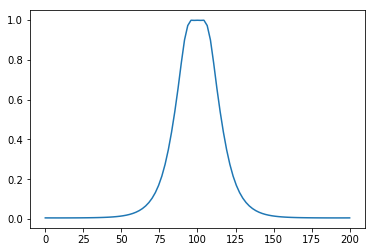

In [27]:
plot(p_adaptive)

In [28]:
       print(
                "step: {0:5}, disp: {5:5.4f},  load: {6:5.2f}, vertices: {1:9.0f}, cells: {2:9.0f}, hmin: {3:5.2f} time: {4:6.0f}".format(
                    step_counter,
                    FunctionSpace(mesh, "CG", 1).dim(),
                    FunctionSpace(mesh, "DG", 0).dim(),
                    MPI.min(comm,mesh.hmin()),
                    time.time() - start,
                    disp_current,
                    -reaction
                ),end = '\n' if min_ms_achieved else '\r'
            )

step:   644, disp: 0.0251,  load:  0.01, vertices:        95, cells:        94, hmin:  2.13 time:     21
